# End-to-end machine learning project


## 1. Frame the problem

**Task / problem** <br>
Create a model to predict median housing prices of districts in California.

**Goal** <br>
Get a good output from the model, ie. good predictions for housing prices. 


**The company's goal** <br>
To feed the output of the model into another ML model which in the end will determine whether or not it is worth investing in a certain area. The current solution to the problem is to predict the housing prices manually. This is time consuming and not accurate (error rate around 20 %). 

**Solution to the problem:** <br>
Making a model to predict the housing prices is a supervised learning task, since the training dataset consists of pairs of input values and desired output values. The task is also a multiple regression problem since the model will use multiple features to make a prediction. The problem will be solved by plain batch learning since there is no continous flow of data coming in and the dataset is small enough to fit in memory.

## 2. Look at the big picture

A performance measure is neccessary to determine how well the model is performing. Two typical ways to measure performance is root mean square of error (RMSE) and Mean Absolute Error (MAE).<br><br>
The MAE is a linear score which means that all the individual differences are weighted equally in the average.
The RMSE is a quadratic scoring rule which measures the average magnitude of the error. 
Since the errors are squared before they are averaged, the RMSE gives a relatively high weight to large errors. This means the RMSE is most useful when large errors are particularly undesirable. MAE is useful when there are many outlier districts. 
<br><br>RMSE performs very well and is generally preferred, assuming that there are few outlier districts (like in a bell-shaped curve). 

$ RMSE (X, h) = \sqrt{(\frac{1}{m})\sum_{i=1}^{m}(h(x^{i}) - y^{i})^{2}} $

- m is the number of instances in the dataset you are measuring the RMSE on. <br>
- $ x^{i} $ is a vector of all the feature values (excluding the label) of the ith instance in
the dataset, and $ y^{i} $) is its label (the desired output value for that instance).<br>
- X is a matrix containing all the feature values (excluding labels) of all instances in
the dataset.<br>
- h is your system’s prediction function, also called a hypothesis.<br>
- RMSE(X,h) is the cost function measured on the set of examples using your
hypothesis h.

## 3. Get the data

The dataset, the California housing prices dataset from Sttlib, was downloaded from the Kaggle competition site. Each row in the dataset represents a housing district and each column is a property which describes the housing district.


### Setup

In [90]:
%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.model_selection import StratifiedShuffleSplit

### Data

To list the files in the data folder the following commmand can be used:

In [91]:
import os
print(os.listdir("data"))

['housing_data.csv', 'housing_test_data.csv', 'openml', 'sample_submission.csv']


The functions below were used to create Pandas DataFrames containing the different datasets.

In [92]:
housing = pd.read_csv('data/housing_data.csv')
test = pd.read_csv('data/housing_test_data.csv')

To get a quick describtion of the data it is useful to inspect the datasets with the head and the info methods. The head method shows the first 10 rows, each representing one district. It also shows 10 different features.

In [93]:
housing.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.13,37.67,40.0,1748.0,318.0,914.0,317.0,3.8676,184000.0,NEAR BAY
1,-120.98,37.65,40.0,422.0,63.0,158.0,63.0,7.3841,172200.0,INLAND
2,-118.37,33.87,23.0,1829.0,331.0,891.0,356.0,6.5755,359900.0,<1H OCEAN
3,-117.89,33.90,23.0,1533.0,226.0,693.0,230.0,7.8980,258200.0,<1H OCEAN
4,-122.40,37.76,52.0,1529.0,385.0,1347.0,348.0,2.9312,239100.0,NEAR BAY
5,-118.10,33.90,40.0,1880.0,377.0,1229.0,378.0,4.4167,174600.0,<1H OCEAN
6,-119.45,36.16,27.0,2119.0,373.0,1268.0,345.0,2.8152,106900.0,INLAND
7,-122.31,38.30,45.0,3023.0,659.0,1789.0,657.0,3.6039,126000.0,NEAR BAY
8,-121.45,38.48,28.0,2780.0,510.0,1638.0,533.0,2.9571,103100.0,INLAND
9,-118.96,35.37,41.0,1463.0,339.0,1066.0,318.0,1.7467,52400.0,INLAND


The info method is useful to get a quick describtion of the data. This includes information such as the total number of rows, each attribute's type and how many non-null values there are for each attribute. This method shows that there are nine numerical features and one non-numerical feature in the dataset. It can also be observed that not all districts has a record of how many bedrooms there are in that district. 

In [94]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16344 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.3+ MB


The data can also be represented in terms of numerical attributes. 
The table below includes count, mean, std, min, max as well as lower, 50 and upper percentiles. By default the lower percentile is 25 and the upper percentile is 75. A percentile is a measure used in statistics indicating the value below which a given percentage of observations in a group of observations falls. The 25th percentile is the value (or score) below which 25% of the observations may be found. The 50 percentile is the same as the median. <br><br>
Note that the different means for each attribute are on different scales. This will be handled with standardization later, as it is important to scale large variables before running linear regression on the dataset. 

In [95]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,16512.000000,16512.000000,16512.000000,16512.000000,16344.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.568763,35.630270,28.714571,2636.885841,537.999755,1425.131783,499.837936,3.871083,207262.390080
std,2.003747,2.137134,12.589203,2195.840228,422.944167,1126.453504,383.400473,1.909994,115838.329585
min,-124.350000,32.540000,1.000000,6.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.790000,33.930000,18.000000,1445.000000,295.000000,787.000000,279.000000,2.562500,120000.000000
50%,-118.490000,34.260000,29.000000,2122.500000,434.000000,1163.000000,409.000000,3.529450,180400.000000
75%,-118.010000,37.710000,37.000000,3137.000000,646.000000,1723.000000,603.000000,4.746450,265100.000000
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000


It can be very useful to take a look at the dataset by plotting a histogram for each numerical attribute. A histogram shows the number of instances (on the vertical axis) that have a given value range (on the horizontal axis). <br>
 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F5BC4B4280>,
      dtype=object)

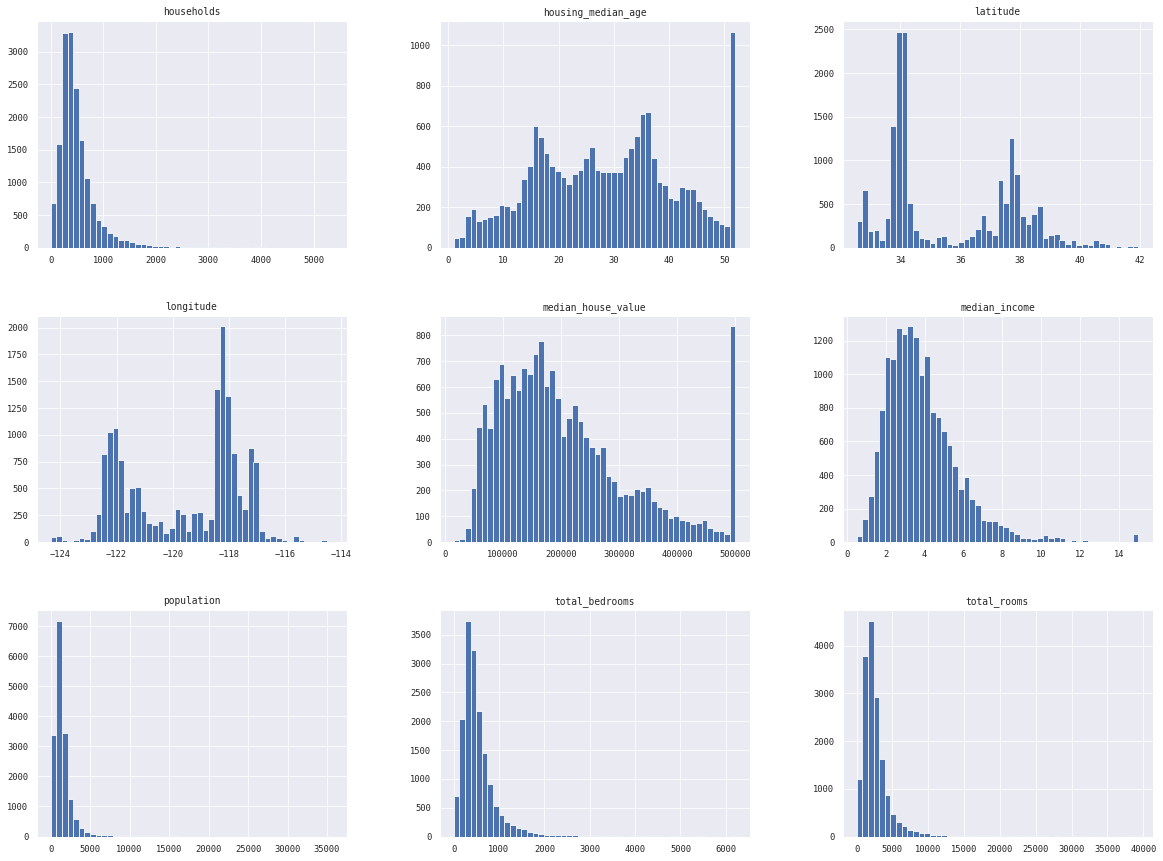

In [96]:
housing.hist(bins=50, figsize=(20,15))

Having a closer look at histograms can provide very useful information. It can be worth noting if any of the distributions are tail-heavy or clustered. 

### Creating a test set

The data set must be seperated into a training set and a test set. To avoid data snooping bias only the training set will be explored to gain insights about the data. Splitting of the dataset can be performed with the train_test_split method shown below:

In [97]:
train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)

### Handling sampling bias

When studying the histograms above, it is observed that the median income is clustered between 15 000 and 60 000. In order to avoid bias one need to ensure that the test set is representative of the various categories of income in the whole dataset. 
This is solved by making sure there are a sufficient number of instances in each stratum/class before doing the splitting of the the dataset into a training set and a test set. 

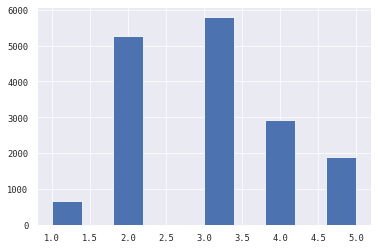

In [98]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0, 1.5, 3.0, 4.5, 6.0, np.inf], labels=[1, 2, 3, 4, 5])
housing["income_cat"].hist()

Now the dataset can be split into a training and a test set without worries about bias:

In [99]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state = 42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

The income proportions in the test set is shown below. Comparing the proportions with the histogram showing the income categories it is concluded that the split was successful.

In [100]:
strat_test_set["income_cat"].value_counts() / len (strat_test_set)

3    0.350590
2    0.318801
4    0.176203
5    0.114441
1    0.039964
Name: income_cat, dtype: float64

To get the data set back to its original state after the splitting into a training and test set, the income categories are removed.

In [101]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# 3. Explore the data and gain insights


As mentioned when splitting the data set into a training and a test set, the test set will be set aside and not handled until the model is ready for testing. In order to examine the training set without any concern of harming it, a copy is made before exploring it in more depth.

In [102]:
housing = strat_train_set.copy()

The data can be visualized by making a scatter plot of all the districts. Setting the values on the x-axis to lonigtude and the y-axis to latitude results in an image that resembles the map of California! <br><br>
The house values are represented by color (red is high and blue is low) and population density by the size of the circles in the plot. Observations made include a high correlation between house prices and population density, the houses are more expensive closer to the big cities. There is also some correlation between housing prices and proximity to the sea, but this correlation is only high in the latitudes below 38 degrees. 

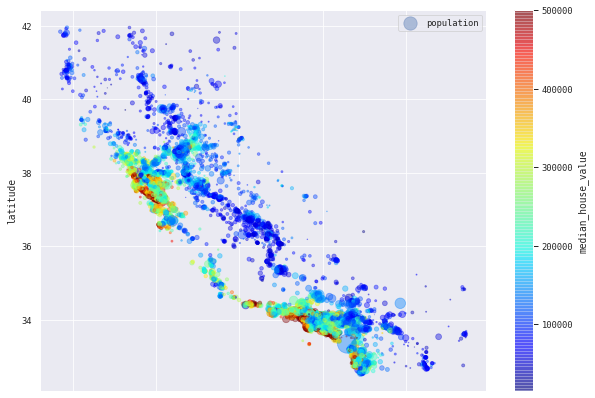

In [103]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, s = housing["population"]/100, label="population", figsize=(10,7), c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,)
plt.legend()

To further investigate correlations the standard correlation coefficient can be computed between every single pair of attributes. The result is shown below. The darker the color, the higher the correlation.

In [104]:
corr_matrix = housing.corr()

In [105]:
corr_matrix.style.background_gradient()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924969,-0.108410,0.044055,0.072069,0.101455,0.059443,-0.016724,-0.041681
latitude,-0.924969,1.000000,0.015056,-0.036093,-0.069573,-0.107070,-0.073323,-0.079611,-0.149024
housing_median_age,-0.108410,0.015056,1.000000,-0.363551,-0.323106,-0.301495,-0.306610,-0.112510,0.106092
total_rooms,0.044055,-0.036093,-0.363551,1.000000,0.929324,0.859160,0.920067,0.199593,0.133077
total_bedrooms,0.072069,-0.069573,-0.323106,0.929324,1.000000,0.878230,0.981919,-0.006025,0.047995
population,0.101455,-0.107070,-0.301495,0.859160,0.878230,1.000000,0.904873,0.008472,-0.026638
households,0.059443,-0.073323,-0.306610,0.920067,0.981919,0.904873,1.000000,0.014203,0.063955
median_income,-0.016724,-0.079611,-0.112510,0.199593,-0.006025,0.008472,0.014203,1.000000,0.685704
median_house_value,-0.041681,-0.149024,0.106092,0.133077,0.047995,-0.026638,0.063955,0.685704,1.000000


Another way to visualize correlation is to plot a Seaborn heatmap. It is similiar to the table above, but many find heatmaps more appealing to the eyes, and they tend to send clear messages about data almost immediately. 

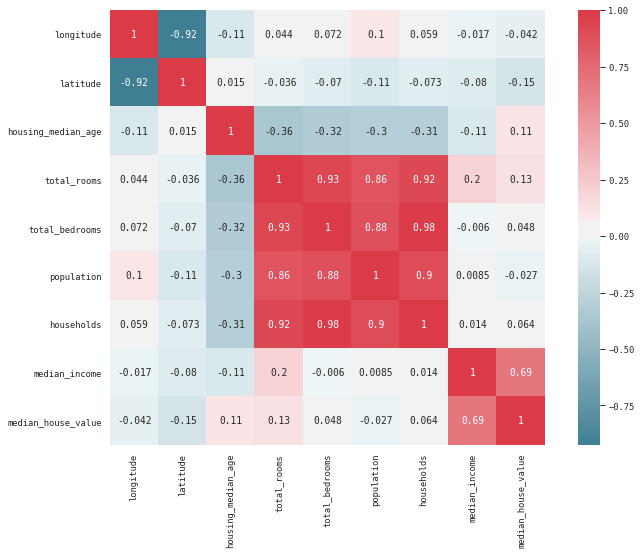

In [106]:
sns.set(context="paper",font="monospace")
fig, axe = plt.subplots(figsize=(12,8))
cmap = sns.diverging_palette(220,10,center = "light", as_cmap=True)
sns.heatmap(corr_matrix,vmax=1,square =True, cmap=cmap,annot=True )

 Below the correlation between median house value and the other attributes is shown as a list:


In [107]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.685704
total_rooms           0.133077
housing_median_age    0.106092
households            0.063955
total_bedrooms        0.047995
population           -0.026638
longitude            -0.041681
latitude             -0.149024
Name: median_house_value, dtype: float64

A correlation coefficient close to 1 means that there is a strong correlation. If the coefficient is around 0 it means that there is no correlation. Finally, if the coefficient is -1 it means that there is a strong negative correlation.

The correlation matrix above shows that housing prices have a slight tendency to decrease when one goes north. This corresponds well with the map created above, whereit can be observed that there are fewer expensive houses in the northern part of California. Another observation is that there is a strong correlation between median house value and median income, the housing prices tend to go up when median income goes up. 

The attributes that had the strongest correlation with median house value were chosen for a closer examination.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F5B479E220>,
      dtype=object)

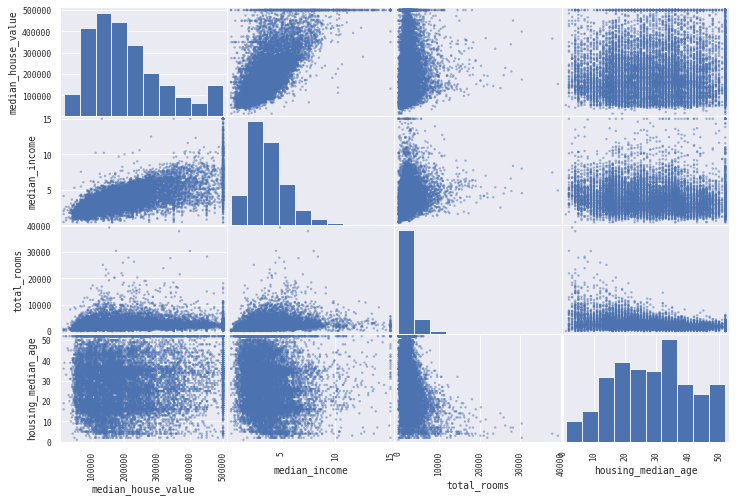

In [108]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"];
scatter_matrix(housing[attributes], figsize=(12,8))

__Observations:__<br>
- There is a correlation between median house value and median income. This is expected as with higher income comes the ability to buy a more expensive house. 
- In the dataset for median house value there is a cap at 500,000 dollars (all house prices above 500,000 dollars are plotted as 500,000 dollars). This can be seen as a straight line in the top histograms, showing median house value on the y-axis. 
- The age of the houses does not seem to influence the value of the house very much, but a small correlation between newer houses and a higher total number of rooms can be seen.  

### Attribute combinations

Some of the attributes in the dataset are not very useful on their own. An example of this is the number of rooms in a district, clearly it is more interesing to know how many rooms there are per household. The code below creates three new attributes, rooms per household, a ratio between bedrooms and total rooms, and finally population per household.

In [109]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

In [110]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.685704
rooms_per_household         0.193628
total_rooms                 0.133077
housing_median_age          0.106092
households                  0.063955
total_bedrooms              0.047995
population_per_household   -0.025622
population                 -0.026638
longitude                  -0.041681
latitude                   -0.149024
bedrooms_per_room          -0.255611
Name: median_house_value, dtype: float64

Looking at the correlation between median house value and the new attributes it is now clear that the ratio between bedrooms and total rooms correlates to the housing price. A lower bedroom/room ratio tend to be more expensive.

# 4. Prepare the data to better expose the underlying data patterns to machine learning algorithms

By once more copying the stratified training set results in a clean training set before data cleaning. The predictors (X) are seperated from the labels/targets (y) and stored in two different datasets. 


In [111]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### Data cleaning

Most algorithms cannot work with missing values so this needs to be handled. It is a common practise to compute the median values and fill them in where values are missing in the trainig set. Thee value is saved so that it can be used in the test set later. 

In [112]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

Non-numerical features must be removed before computing the medians for each feature. In this dataset the ocean proximity is the only non-numerical feature. 

In [113]:
housing_num = housing.drop("ocean_proximity", axis=1)

In [114]:
imputer.fit(housing_num)
imputer.statistics_

array([-118.49  ,   34.25  ,   29.    , 2116.    ,  433.    , 1163.    ,
        409.    ,    3.5288])

The array above shows the calculated medians for eight of the ten features in our dataset. Ocean proximity was dropped since it was not a numerical feature, and the labels are not calculated for obvious reasons. By using the imputers's transform method, all the missing values in the dataset will be replaced with the median value. Since the result is a numpy array it needs to be put back into a pandas DataFrame. 

In [115]:
housing_transformed = imputer.transform(housing_num)
housing_tr = pd.DataFrame(housing_transformed, columns=housing_num.columns, index=housing_num.index)

### Text values

To deal with the non-numerical features, like the ocean proximity, the different text values can be converted into numbers.

In [116]:
housing_cat = housing[["ocean_proximity"]]

In [117]:
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder()
housing_cat_encoded = ord_enc.fit_transform(housing_cat)

Changing the text values to numbers will make the ML algorithms think that the numeric values (0-4) will have a meaning. For example that two nearby categories will be similar. This is not the case for the values for ocean proximity, the categories are not sorted in any way. Two categories that are similar will not neccessarily be next to each other. This can make the model perform different than how it is supposed to. This is handled by using a binary attribute for every category. The resulting sparse matrix is then converted to a NumPy array.

In [118]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_hot = encoder.fit_transform(housing_cat_encoded)
housing_cat_hot
housing_cat_hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

The non-numerical categories and the corresponding numerical categories are shown below. 

In [119]:
ord_enc.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [120]:
encoder.categories_

[array([0., 1., 2., 3., 4.])]

Below is how the ocean proximity, represented by binary attributes, will be shown in the dataset:

In [121]:
housing_binary = pd.DataFrame(housing_cat_hot.toarray())
housing_binary.head()

,0,1,2,3,4
0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0


### Custom transformers

It is useful to make a function for combining attributes (like done before to check for correlation between rooms and house prices). This transformer has a hyperparameter, add_bedrooms_per_room, set to True. This parameter will help determine if adding this attribute helps the machine learning algorithms or not. 

In [122]:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [123]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [124]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-118.15,34.12,52,1518,344,725,296,3.4018,<1H OCEAN,5.12838,2.44932
1,-117.88,34.12,34,912,165,522,150,4.0417,<1H OCEAN,6.08,3.48
2,-121.09,37.33,40,524,112,329,96,1.7188,INLAND,5.45833,3.42708
3,-118.24,33.99,41,1425,372,1803,353,1.6731,<1H OCEAN,4.03683,5.10765
4,-122.4,37.72,37,971,248,647,208,2.1187,NEAR BAY,4.66827,3.11058


Above is the dataset with the new columns for rooms per household and population per household. 

### Feature scaling

Machine Learning algorithms don't perform well when the input numerical attributes have very different scales. There are two ways to get all the attributes to have the same scale, min-max scaling (normalization) and standardization. 

Standardization transforms data to have a mean of zero and a standard deviation of 1. For this model standardization will be used. Since there are many transformation steps to be executed it can be handy to use Scikit-Learn's Pipeline class to help with the sequences of transformations. The following code will perform the previous described transformations of: 
- replacing missing values with the median value, 
- combining attributes to make new attributes,
- standardization. 

In [125]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

The transformation of the ocean proximity text values into binary attributes is handled by Scikit-Learn's ColumnTransformer.  The appropriate transformations are applied to the data in sequence.

In [126]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

In [127]:
housing_prepared = full_pipeline.fit_transform(housing)

In [128]:
housing_prepared_df = pd.DataFrame(
    housing_prepared, 
    columns=list(housing_num.columns)+["rooms_per_household", "population_per_household", "bedrooms_per_room",  "bin0", "bin1", "bin2", "bin3", "bin4"])
housing_prepared_df.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,population_per_household,bedrooms_per_room,bin0,bin1,bin2,bin3,bin4
0,0.707978,-0.703639,1.857386,-0.510659,-0.460042,-0.621227,-0.533127,-0.247245,-0.139493,-0.053438,0.193052,1.0,0.0,0.0,0.0,0.0
1,0.843185,-0.703639,0.422241,-0.787398,-0.886967,-0.800501,-0.914085,0.087831,0.361095,0.031175,-0.500171,1.0,0.0,0.0,0.0,0.0
2,-0.764279,0.802627,0.900622,-0.964584,-1.013375,-0.970944,-1.054988,-1.128529,0.034075,0.026831,-0.002257,0.0,1.0,0.0,0.0,0.0
3,0.662909,-0.764640,0.980353,-0.553128,-0.393260,0.330778,-0.384396,-1.152459,-0.713689,0.164798,0.715533,1.0,0.0,0.0,0.0,0.0
4,-1.420285,0.985631,0.661431,-0.760455,-0.689007,-0.690111,-0.762746,-0.919126,-0.381528,0.000848,0.629878,0.0,0.0,0.0,1.0,0.0
5,1.283861,-0.342323,0.023589,0.000350,-0.059352,-0.212342,-0.141731,-0.462880,0.273013,-0.035841,-0.299318,0.0,1.0,0.0,0.0,0.0
6,0.637870,-0.727101,-0.375063,0.632376,2.790793,2.029906,2.684147,-1.119260,-1.453825,-0.054405,3.195572,1.0,0.0,0.0,0.0,0.0
7,-1.104801,0.614930,-0.693984,-0.022483,0.024125,0.093219,0.103544,-0.752190,-0.317103,-0.021305,-0.037130,1.0,0.0,0.0,0.0,0.0
8,0.597809,-0.802180,0.980353,-0.350369,-0.262082,-0.083406,-0.170433,0.032220,-0.577065,-0.002757,0.221125,1.0,0.0,0.0,0.0,0.0
9,-1.650638,2.318278,-1.331827,-0.587378,-0.564984,-0.887930,-0.856681,-1.117794,1.291568,-0.052619,0.126423,0.0,1.0,0.0,0.0,0.0


Above a preview of the dataset is shown, after it has been through the transformation pipeline. 

# 5. Explore many different models and short-list the best ones

### Training and evaluating on the training set

#### Linear regression

The following code trains a linear regression model on the prepared training set.

In [129]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

The model can be tested with some instances from the training set.

In [130]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("The predicted values:\t", lin_reg.predict(some_data_prepared))
print("The actual values:\t", list(some_labels))

The predicted values:	 [229160.3070257  212665.75854606  98082.80265673 122004.73357883
 176186.91927408]
The actual values:	 [204500.0, 178000.0, 112500.0, 88200.0, 239300.0]


Observe that the predictions are not very accurate. Measuring RMSE on the training set shows a typical prediction error of around 69,000 $:

In [131]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

69189.070349375

This is an example of model underfitting and it is probably because the features do not provide enough information to make good predictions. Another possibility is that the model is not poweful enough. There are three options to deal with underfitting:

- select a more powerful model
- feed the training algorithm better features
- reduce the constraints on the model

In this situation a more powerful model is probably a good way to try to improve the predictions.

#### Decision tree regressor

Decision trees are versatile algorithms that can perform both classification and regression tasks. They are capapable of fitting complex datasets. 

In [132]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [133]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

It is not very likely that the error is zero, that would mean that the perfect model has been created. A disadvantage of decision tree regressors are that overcomplex trees can be created, these trees do not generalize the data well. This is called overfitting and that is most likely what is happening here. To find out how the model performs a validation dataset can be used. This is a sample of data held back from training your model. It is used to give an estimate of the model performance and decide a model among different models. 

### Cross-validation

There are different ways to create and use a validation set. The hold-out method is the simplest kind of validation. The data set is separated into two sets, a training set and the validating set. The model can then be tested on the validation set. 

Cross-validation, or k-fold cross-validation, is when the dataset is randomly split up into k groups. One of the groups is used as the validating set and the rest are used as the training set. The model is trained on the training set and scored on the validating set. Then the process is repeated until each unique group as been used as the validating set.

When the results are satisfactory, the model can finally be tested with the test set that was set aside in the beginning of the project.

Cross-validation is usually the preferred method because it gives the model the opportunity to train on multiple train-validation splits. This gives you a better indication of how well your model will perform on unseen data. 

In [134]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [135]:
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard deviation: ", scores.std())

In [136]:
display_scores(tree_rmse_scores)

Scores:  [69257.93740839 74276.95506545 72781.00749384 68803.35098945
 72034.06549587 69766.06816543 75827.41735721 74218.38519452
 71549.23312439 71653.33894004]
Mean:  72016.7759234588
Standard deviation:  2200.3292475468797


The results are not as good as hoped for, the score is appoximately 70,800, generally +/- 3,000. The standard deviation shows how precise the estimate of the performance is. To compare the decision tree model, cross-validation is performed for the linear model as well:

In [137]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores:  [67425.31111647 70545.68245901 65275.34487036 72985.99852065
 66010.80255207 70540.06026376 73335.57983319 70614.41958818
 71803.70040712 67678.50408007]
Mean:  69621.54036908635
Standard deviation:  2703.417700170707


The linear model actually performs a little better, showing how bad the overfitting of the decision tree model is. Let's try some more models.

#### Random forest regressor

In [138]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores:  [50646.27298937 52432.14712892 50373.40344679 49316.0395564
 49005.85897763 53740.60821391 55801.7432575  50707.88643582
 51066.98463865 49230.72963673]
Mean:  51232.167428173154
Standard deviation:  2064.700997015439


The cross validation of the random forests model looks much better than the previous two models, and this model will be chosen for fine-tuning.

# Fine-tune the models and combine them into a great solution

### Grid search

Instead of manually changing the hyperparameters until finding a great combination, one option is to perform a grid search. This method uses cross-validation to evaluate possible combinations of selected hyperparameters values. 

In [139]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'n_estimators': [3, 10, 40], 'max_features' : [2, 4, 5, 6]},
    {'bootstrap':[False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv = 5, scoring = 'neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 5, 6],
                          'n_estimators': [3, 10, 40]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

The best combination of parameters turns out to be 5 and 40:

In [140]:
grid_search.best_params_

{'max_features': 5, 'n_estimators': 40}

Checking out the evaluation scores confirms this. Setting the max_features to 5 and the n_estimators to 40 gives a RMSE score of 50,881 which is slightly better than the RMSE score from the random forest model of 51,050. 

In [141]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64456.53755736674 {'max_features': 2, 'n_estimators': 3}
56212.549607526664 {'max_features': 2, 'n_estimators': 10}
53180.8373629973 {'max_features': 2, 'n_estimators': 40}
60758.91138440394 {'max_features': 4, 'n_estimators': 3}
53948.65181002317 {'max_features': 4, 'n_estimators': 10}
51215.778984467026 {'max_features': 4, 'n_estimators': 40}
61472.92366460231 {'max_features': 5, 'n_estimators': 3}
54360.86836420878 {'max_features': 5, 'n_estimators': 10}
50881.27680634082 {'max_features': 5, 'n_estimators': 40}
59589.10501235491 {'max_features': 6, 'n_estimators': 3}
52968.40337999665 {'max_features': 6, 'n_estimators': 10}
51029.00878068642 {'max_features': 6, 'n_estimators': 40}
63129.31651768439 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54783.01842237063 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60728.179712757665 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53862.955974355915 {'bootstrap': False, 'max_features': 3, 'n_estimators':

#### Randomized search

For comparison a randomized search was performed. The result here is to set the n_estimator to 44 and the max_features to 5. This gives a RMSE score of 50,838. This is close to the RMSE score from the grid search.

In [142]:
from sklearn.model_selection import RandomizedSearchCV

param_ran = {'n_estimators': list(range(1,100)), 'max_features': list(range(1, 10))}
clf = RandomizedSearchCV(forest_reg, param_distributions=param_ran, random_state=42, cv=5, scoring='neg_mean_squared_error',)
ran_search = clf.fit(housing_prepared, housing_labels)

In [143]:
ran_search.best_params_

{'n_estimators': 44, 'max_features': 5}

In [144]:
ran_cvres = ran_search.cv_results_
for mean_score, params in zip(ran_cvres["mean_test_score"], ran_cvres["params"]):
    print(np.sqrt(-mean_score), params)

52017.167893397775 {'n_estimators': 17, 'max_features': 8}
50838.436001487404 {'n_estimators': 44, 'max_features': 5}
50914.80005973583 {'n_estimators': 49, 'max_features': 9}
51302.36486680338 {'n_estimators': 28, 'max_features': 8}
55765.640006782894 {'n_estimators': 40, 'max_features': 1}
51145.99514955714 {'n_estimators': 93, 'max_features': 3}
58142.07328453113 {'n_estimators': 4, 'max_features': 4}
51253.620136439415 {'n_estimators': 37, 'max_features': 4}
54501.9874254014 {'n_estimators': 11, 'max_features': 3}
53242.60955243234 {'n_estimators': 38, 'max_features': 2}


#### Analyze the model and its errors

Inspecting the model can indicate the relative importance of each attribute for making accurate predictions:

In [145]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([0.0748187 , 0.06848348, 0.04264568, 0.02088776, 0.01874604,
       0.02048508, 0.01893562, 0.31740228, 0.06857602, 0.10724477,
       0.0826846 , 0.01349175, 0.13607912, 0.00033752, 0.00284029,
       0.0063413 ])

In [146]:
extra_attribs = ["rooms_per_household", "population_per_household", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3174022833278303, 'median_income'),
 (0.1360791150720603, 'INLAND'),
 (0.10724477062590854, 'population_per_household'),
 (0.08268459689298549, 'bedrooms_per_room'),
 (0.0748186987750621, 'longitude'),
 (0.06857601975009081, 'rooms_per_household'),
 (0.06848347971797611, 'latitude'),
 (0.0426456764030867, 'housing_median_age'),
 (0.020887757632918308, 'total_rooms'),
 (0.020485080192261817, 'population'),
 (0.018935616719191563, 'households'),
 (0.01874603722599567, 'total_bedrooms'),
 (0.013491753464299119, '<1H OCEAN'),
 (0.006341295393227461, 'NEAR OCEAN'),
 (0.002840293932904009, 'NEAR BAY'),
 (0.0003375248742017836, 'ISLAND')]

With this kind of information one can consider to drop some of the less useful features from the model. Observe that only one of the ocean proximity categories is useful. One possibility is therefore to train the model on a dataset where ocean proximity is a boolean for category ('INLAND').

#### Evaluate the system on the test set

In [147]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_prediction = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_prediction)
final_rmse = np.sqrt(final_mse)
final_rmse

49735.3951890455

Below is a graph showing how the model has performed. The actual house values are seen as the blue line, and the predicted values are orange. The model performs well on some districts, but overestimate the price greatly for other districts. 

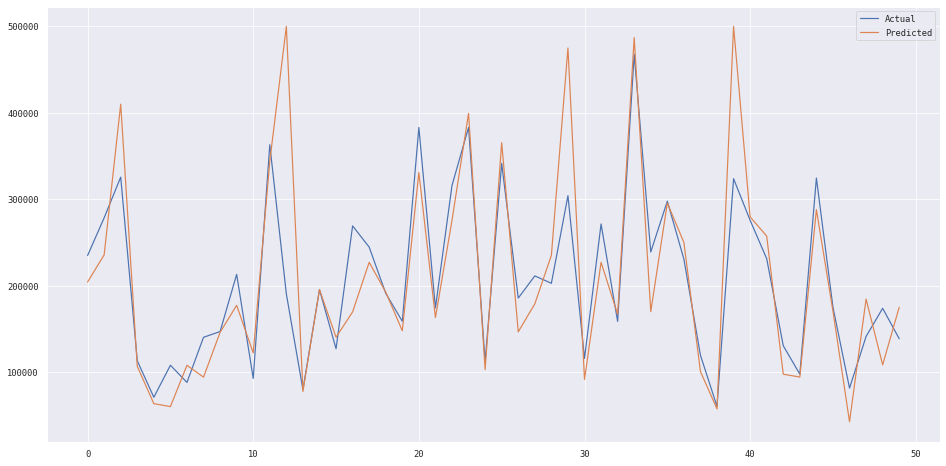

In [148]:
data = pd.DataFrame({'Predicted': final_prediction, 'Actual': y_test})
fig = plt.figure(figsize = (16,8))
data = data.reset_index()
data = data.drop(['index'],axis = 1)
plt.plot(data[:50])
plt.legend(['Actual','Predicted'])

#### Computing a 95% Confidence interval

In [149]:
from scipy import stats

confidence  = 0.95
squared_errors = (final_prediction - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([47118.75579772, 52221.08694096])

In [150]:
final_model.score(X_test_prepared, y_test)

0.8131811769530889

Final score of 81.3 %.

#### XGBoost

In order to perform better in the Kaggle competition, we wanted to try out XGBoost. <br> 
XGBoost is an optimized implementation of Gradient Boosting. Gradient Boosting works by sequentially adding predictiors to an ensamble, each one correcting its predecessor. The method tries to fit the new predictor to the residual errors made by the previous predictor.

XGBoost performs very well in machine learning competitions, and it is available from the XGBoost library. 

In [151]:
import sys
!{sys.executable} -m pip install xgboost

In [152]:
import xgboost
xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(housing_prepared, housing_labels)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [153]:
xgb_scores = cross_val_score(xgb_reg, housing_prepared, housing_labels,scoring="neg_mean_squared_error", cv=10)
xgb_rmse_scores = np.sqrt(-xgb_scores)
display_scores(xgb_rmse_scores)

Scores:  [50500.19797218 47808.07553065 47270.14533036 45910.64031548
 46451.11583465 50680.86062043 52459.3873726  48067.01876313
 47177.74626856 44552.93998027]
Mean:  48087.81279883117
Standard deviation:  2305.294619166342


This model performs better than our previous models. Let's use it on our test set!

In [154]:
final_model = xgb_reg

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_prediction = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_prediction)
final_rmse = np.sqrt(final_mse)
final_rmse

47676.88791186405

In [155]:
final_model.score(X_test_prepared, y_test)

0.8283257004845245

Final score 82.8 %

# Present the solution

#### Evaluation and conclusion

In this project the California Housing Prices dataset has been analyzed. The dataset had the following features per district in California:

- location in terms of longitude and latitude
- median age of housing
- total rooms
- total bedrooms
- total population
- total households
- median income
- median housing price
- ocean proximity

Which properties had the highest correlations was analyzed, and it was concluded that the number one predictor of housing prices was the median income. 

The following steps have been done: 
- exploring the data, 
- transforming data to better fit into the machine learning algorithms, 
- testing different models,
- picking one model and fine-tuning it.

The result was an accuracy of 81,3 %.

The final performance is not better than the manual predictions of the experts. But the model will still free up a lot of time by automating the task of predicting housing prices.


# Launch, monitor and maintain the system

After creating the model the following work needs to be done:

- Write monitoring code for checking performance.
- Human evaluation.
- Evaluate the input data quality.
- Monitoring
- collect fresh data
- Train and fine-tune the model automatically
- Evaluate the new versions of the model compared to the older ones
- ...


When the system is lauched its important to write monitoring code to check the system's live performance. Models tend's to "rot" over time if the models is not being trained on fresh data.

Maybe the most important thing is to be sure that the system's input data quality is good. If the data quality decreases it may take some time before the monitoring systems pick this up for the system.

It's important to train the models on regular basis, or else the system's performance will decrease drastically over time. If the system is an online learning system a good thing to do is taking snapshot. Such that if the performance decreases because of bad data, we can allways roll back to a previously state.

# Submission

After you have trained your model and have found predictions on your test data, you must create a csv-file that contains 'Id' and your predictions in two coloums

We have assumed that you have called your predicitons 'median_house_value' after you have trained your model

This is just for demonstrational purposes, that is why all our predictions is zero. Yours will be filled with numbers


In [156]:
median_house_value = [0 for i in test['Id']]

In [157]:
test_prepared = full_pipeline.transform(test)

C:\Users\synno\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "


In [158]:
predictions = final_model.predict(test_prepared)

In [159]:
submission = pd.DataFrame({'Id': test['Id'], 'median_house_value': predictions})

In [160]:
submission.head()

,Id,median_house_value
0,0,243964.531250
1,1,278206.812500
2,2,73514.703125
3,3,145786.234375
4,4,45178.953125


In [161]:
# Stores a csv file to submit to the kaggle competition
submission.to_csv('submission.csv', index=False)